# **Lab 5: Wide & Deep Neural Networks**

- Eileen Garcia: 48241821
- Reece Iriye: 48255107
- Trevor Dohm: 48376059

## **0: Imports**

In [14]:
# Some standard Data Science libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Scikit-learn Imports
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics as mt

# Tensorflow Imports
import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Pytorch imports
import torch
from torch.utils.data import Dataset, DataLoader

# Standard library imports
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings("ignore")

## **1: Preparation**

Let's begin by loading the dataset.

In [15]:
df_original_csv: pd.DataFrame = pd.read_csv("Dataset/corona.csv")
df_original_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               278848 non-null  int64 
 1   Test_date            278848 non-null  object
 2   Cough_symptoms       278596 non-null  object
 3   Fever                278596 non-null  object
 4   Sore_throat          278847 non-null  object
 5   Shortness_of_breath  278847 non-null  object
 6   Headache             278847 non-null  object
 7   Corona               278848 non-null  object
 8   Age_60_above         151528 non-null  object
 9   Sex                  259285 non-null  object
 10  Known_contact        278848 non-null  object
dtypes: int64(1), object(10)
memory usage: 23.4+ MB


After printing out some basic information about the dataset, we can note a few things:
- The dataset includes mostly categorical features and we will need to one-hot encode these features.
- "Ind_ID" and "Test_date" will likely be irrelevant, or at least shouldn't be used for prediction purposes when deployed since we want to predict if a patient has COVID-19 based on symptoms, not time.
- We want to remove instances missing values from the columns "Cough_symptoms", "Fever", "Sore_throat", "Shortness_of_breath", and "Headache" since there are so few instances missing that data.
- We may want to consider removing instances with missing values in the "Sex" columns. It would remove only about 19,563 instances. 
- The "Age_60_above" column has about 127,000 missing values. That is too many instances to remove without risking overfitting from lack of data. We may need to impute them, or remove the column entirely, or use "None" as its own category within the feature if the age turns out to be a strong predictor of whether the patient has contracted COVID-19.

In [16]:
# Dataset Size
row_count, col_count = df_original_csv.shape
print(f"The dataset contains {row_count} rows and {col_count} columns.")

The dataset contains 278848 rows and 11 columns.


The original dataset contains nearly 279,000 instances and 11 features, including the target variable: "Corona".

### **1.1: Define and Prepare Class Variables**


Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required.

As part of our data preparation process, one crucial step is identifying and understanding the distribution of missing values in our dataset. This helps us make informed decisions about data cleaning and imputation strategies. Understanding missing data distribution is essential before we apply any transformation, scaling, or encoding to the class variables. 

Depending on the findings, we may need to perform imputation for missing values, or remove features if they are excessively sparse. The heatmap below guide our decision to refine and prepare the dataset for the intended analysis. 

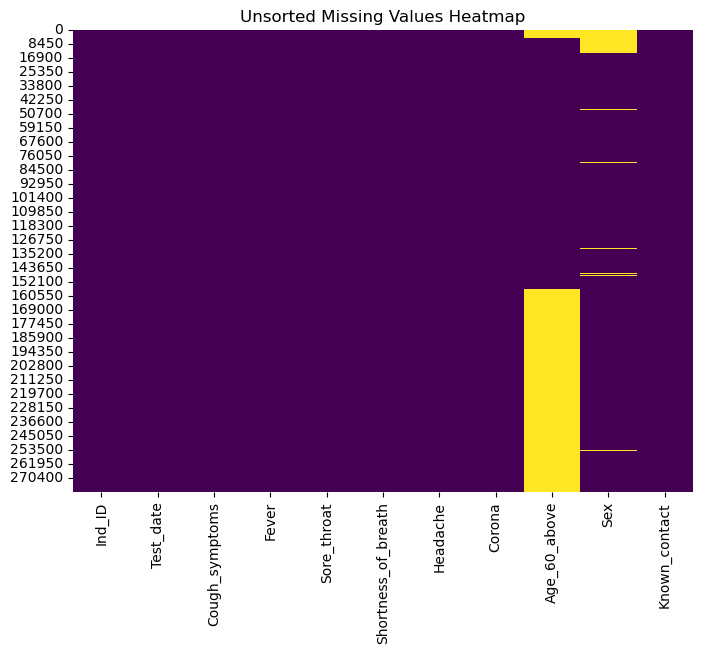

In [17]:
# Exploring Missing Data - ChatGPT 
# Create a boolean DataFrame where True indicates missing values

missing_values = df_original_csv.isnull()

plt.figure(figsize=(8,6))
sns.heatmap(missing_values, cmap='viridis', cbar=False)
plt.title('Unsorted Missing Values Heatmap')
plt.show()

The heatmap shows that the variable "Age_60_above" has a significant amount of missing values. We can also see that the variable "Sex" also has some missing values, but not enough to be alarming. Otherwise, the heatmap shows missing values for the features "Cough_symptoms" and "Fever" as well. We need to find out exactly how many missing values there are in each feature.

The bar plot below provides a comparative visualization of missing values across different features, while excluding the disproportionately affected 'Age_60_above' feature. The decision to exclude the 'Age_60_above' feature from this plot is to prevent its high missing value count from skewing the visualization and obscuring insights into other features.

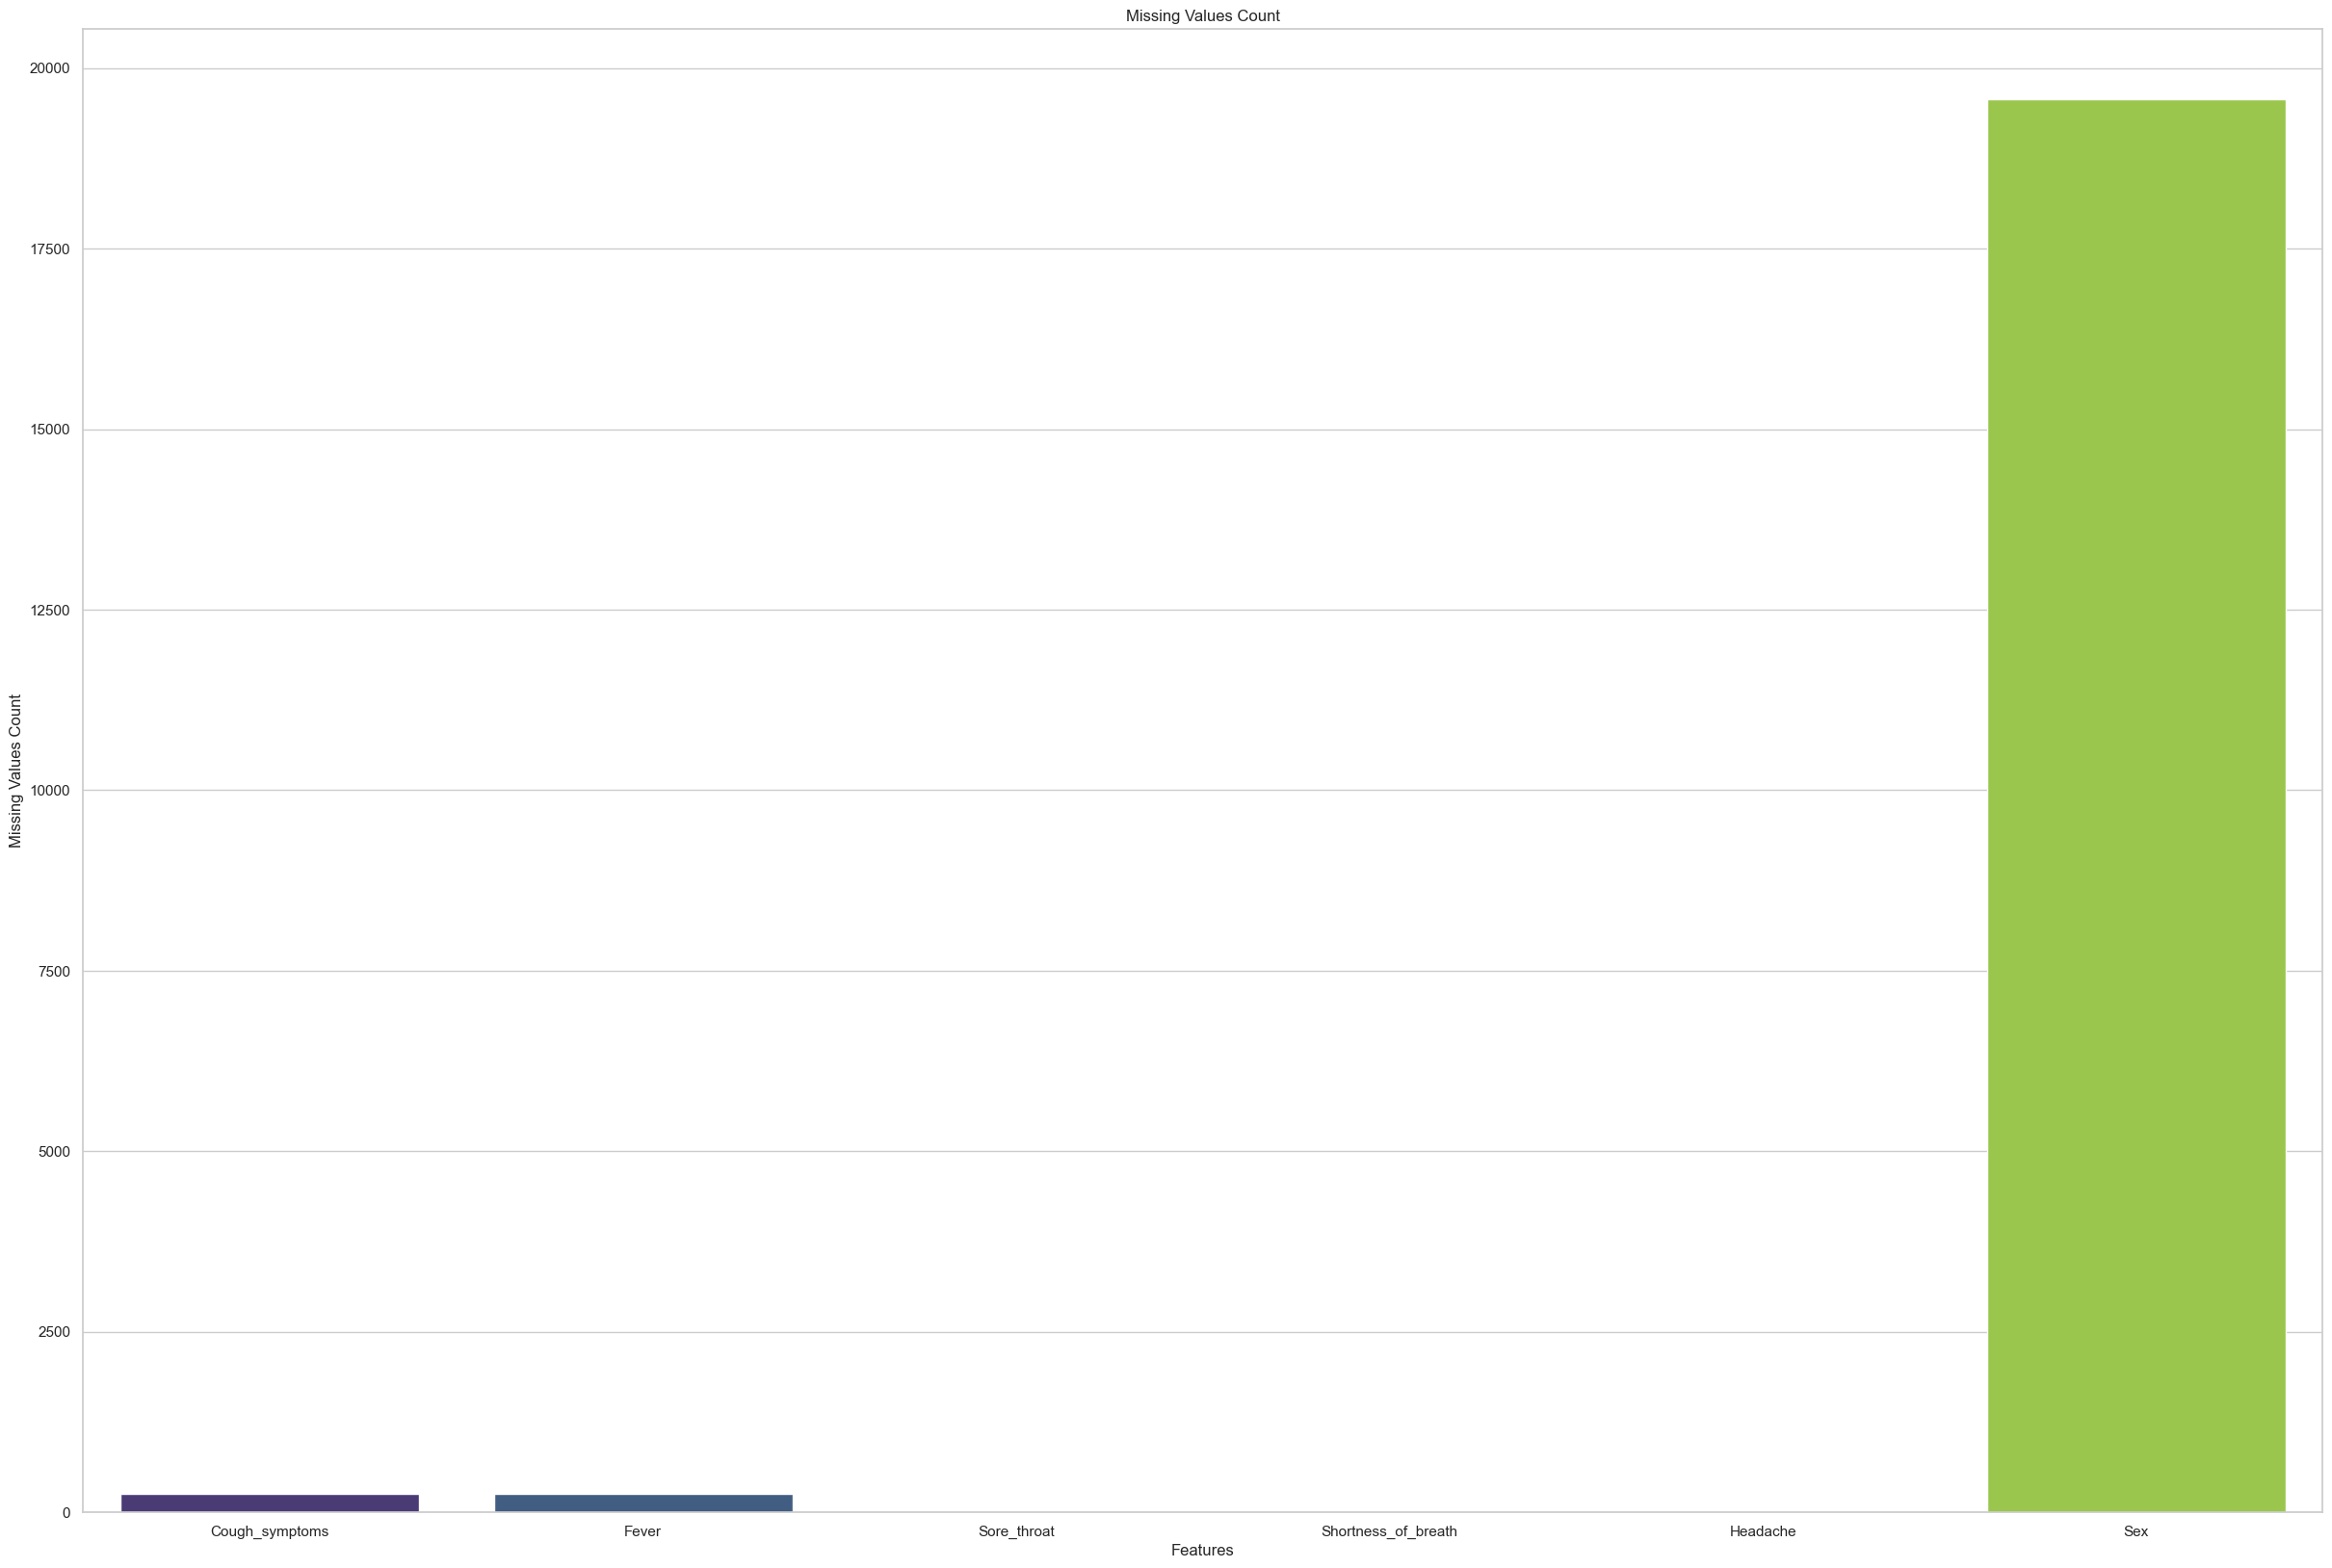

In [18]:
# Bar Plot of missing Values

# Find Missing Values (Sort)
missCount = df_original_csv.isnull().sum()[df_original_csv.isnull().sum() > 0]
# "age_60_above" kind of dwarfs every other variable, with over 100,000 missing values
# Lets plot without that variable
missCount = missCount[missCount > 0].drop(['Age_60_above'])
sns.set(style = "whitegrid")
plt.figure(figsize=(30, 20))
sns.barplot(x = missCount.index, y = missCount.values, palette = "viridis")
plt.title('Missing Values Count')
plt.xlabel('Features')
plt.ylabel('Missing Values Count')
plt.show()

The bar plot only includes features with missing values, meaning features with 1 or more missing values. We can see that "Sex" contains nearly 20,000 missing values, so we will need to choose a preprocessing method to edit or remove those values. "Cough_symptoms" and "Fever" have a few missing values, but less than 100, so we can conclude that simplying removing those instances is sufficient. The same is true for "Sore_throat", "Shortness_of_breath", and "Headache", all of which have a very small number of missing values.

In [19]:
# Removing (Some) Instances with Missing Values
# List of columns to check for missing data, excluding 'Age_60_above'
columns_to_consider = df_original_csv.columns.difference(['Age_60_above'])

# Remove observations with missing data in the specified columns
df_modified = df_original_csv.dropna(subset=columns_to_consider, inplace=False)

# Dataset Size - reduced by the number of dropped instances
row_count, col_count = df_modified.shape
print(f"The dataset contains {row_count} rows and {col_count} columns.")

The dataset contains 259042 rows and 11 columns.


After removing the missing instances in the aforementined columns and removing the column "Age_60_above", we are left with 259,042 rows and 11 columns.

Let's explore "Age_60_above" further. We can calculate the percentage of missing values in the column. 

In [21]:
# Still have about 140,000 missing 'Age_60_above' values
# Calculate the percentage of each unique value in the 'Age_60_above' column
value_counts_percentage = df_modified['Age_60_above'].value_counts(normalize=True, dropna=False) * 100

# Print out the percentages
print("Percentage of each unique value in the 'Age_60_above' column:")
print(value_counts_percentage)

# Unfortunately, we notice that NaN is 46% of the whole column
# In this case, imputation is not an option.

Percentage of each unique value in the 'Age_60_above' column:
Age_60_above
NaN    46.660387
No     44.043823
Yes     9.295790
Name: proportion, dtype: float64


Unfortunately, 48% of the data for "Age_60_above" is missing. In this case, we will remove the entire feature from the dataset because the missing values are too prevalent in the dataset, and imputing may skew the data unintentionally or introduce bias. Furthermore, while 'Age_60_above' might be a strong predictor for whether a person may die from COVID-19, it is likely not a strong predictor for whether or not a person catches COVID-19. 

In [22]:
# Delete the Column 'Age_over_60'
df_modified.drop('Age_60_above', axis=1, inplace=True)
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259042 entries, 13727 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               259042 non-null  int64 
 1   Test_date            259042 non-null  object
 2   Cough_symptoms       259042 non-null  object
 3   Fever                259042 non-null  object
 4   Sore_throat          259042 non-null  object
 5   Shortness_of_breath  259042 non-null  object
 6   Headache             259042 non-null  object
 7   Corona               259042 non-null  object
 8   Sex                  259042 non-null  object
 9   Known_contact        259042 non-null  object
dtypes: int64(1), object(9)
memory usage: 21.7+ MB


Next, we identify and remove variables that do not contribute meaningfully to the analysis or predictive modeling, and therefore simplify the dataset.

In predictive modeling for medical outcomes, such as COVID-19 status, the focus is typically on symptoms, test results, and demographic information rather than individual identifiers or dates such as "Ind_ID" or "Test_date". 

In [23]:
 # Delete Unnecessary Columns
df_modified.drop(['Ind_ID', "Test_date"], axis=1, inplace=True)
df_modified.info()

# Dropping Ind_ID because it is a unique identified
# Dropping Test_date because it is not relevant for predicting the COVID status of a person in the future

<class 'pandas.core.frame.DataFrame'>
Index: 259042 entries, 13727 to 278847
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Cough_symptoms       259042 non-null  object
 1   Fever                259042 non-null  object
 2   Sore_throat          259042 non-null  object
 3   Shortness_of_breath  259042 non-null  object
 4   Headache             259042 non-null  object
 5   Corona               259042 non-null  object
 6   Sex                  259042 non-null  object
 7   Known_contact        259042 non-null  object
dtypes: object(8)
memory usage: 17.8+ MB


It is important to understand the distribution of the target variable. This step is important to ensure that the variable is suitably formatted and assess whether the dataset is balanced or skewed towards a certain class. In binary classification tasks, we need to have a target variable with two categories. The presence of the third category necessitates further discussion.

In [24]:
# Let's check the target variable to make sure we have 2 categories
# Calculate the percentage of each unique value in the 'Corona' column
value_counts_percentage = df_modified['Corona'].value_counts(normalize=True, dropna=False) * 100

# Print out the percentages
print("Percentage of each unique value in the 'Corona' column:")
print(value_counts_percentage)

# We have 1.3% "Other" 

Percentage of each unique value in the 'Corona' column:
Corona
negative    93.473645
positive     5.223863
other        1.302491
Name: proportion, dtype: float64


The presence of the "Other" class could represent a class that is not clearly positive or negative, or it could be a placeholder for missing data. 

We have a few options. 

Options:

- Replace with Positive or Negative: If "Other" is determined to be similar to "positive" or "negative" cases based on domain knowledge or data patterns, we can recode it accordingly. This is a strong assumption and could skew results if not done with proper justification.

- Delete the Rows: If "Other" cannot be reliably classified as either "positive" or "negative," and if its inclusion is not critical to the analysis, it may be simplest to remove these rows from the dataset.

- Impute: If there's a systematic way to impute "Other" based on other features in the dataset, this could be an option. However, this can be complex and requires a strong justification.

Our Approach to Decide:

We are going to perform an analysis of the nature of these "Other" observations. We will perform a cluster analysis to see if the "Other" cases group with "positive" or "negative" cases, to see if replacing "Other" with "positive" or "negative" is feasible. 

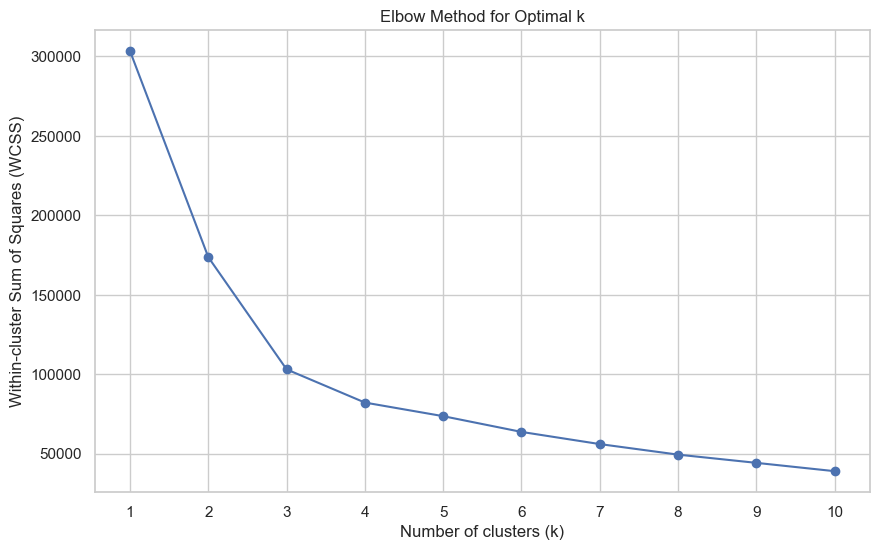

In [25]:
from sklearn.cluster import KMeans

df_cluster_purpose = df_modified.copy()

encoder = OneHotEncoder()

# Apply the encoder to the categorical data, excluding the 'Corona' target variable
df_encoded = encoder.fit_transform(df_cluster_purpose.drop(columns='Corona'))

df_encoded_array = df_encoded.toarray()

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # Within-cluster sum of squares

# Determine the range of k values to try
# We'll try k from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_encoded_array)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for KMeans

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

First, we need to decide the optimal number of clusters for a K-Means cluster analysis. We tried 1-10 clusters to output the scree plot above. Based on the location of the knee, we decide that 3 clusters is optimal for this situation. 

Let's take a look at the distribution of "Corona" classes when we choose the number of clusters to be 3. 

In [26]:
# Choose the number of clusters to be 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_encoded_array)

# Add the cluster labels back to the DataFrame
df_cluster_purpose['Cluster'] = clusters

# ChatGPT helped generate the code below:
# See the distribution of 'Corona' categories within each cluster:
cluster_distribution = df_cluster_purpose.groupby('Cluster')['Corona'].value_counts(normalize=True) * 100

print("Cluster distribution for each 'Corona' category:")
print(cluster_distribution)

Cluster distribution for each 'Corona' category:
Cluster  Corona  
0        negative    83.336150
         positive    15.123270
         other        1.540579
1        negative    95.000328
         positive     3.679093
         other        1.320580
2        negative    95.790832
         positive     3.013125
         other        1.196043
Name: proportion, dtype: float64


The output from the clustering analysis provides insight into how the cases labeled as "negative", "positive", and "other" in the 'Corona' column are distributed across the three clusters identified by the K-Means algorithm.

Cluster 0 contains a significant portion of negative cases, and contains a considerable representation of positive cases (15.12%). Cluster 0 contains a small fraction of Other cases.

Cluster 1 is also dominated by negative cases and positive cases are less prevalent than in Cluster 0. Other cases are, predictably, once again the smallest group.

Cluster 2 is similar in distribution to Cluster 1 with a high prevalance of negative cases and only 3% of positive cases. Other cases are present only slightly less often than in Cluster 1. 

From these statistics, we can say that Cluster 0 captures a different profile that is more associated with positive cases, while the other two clusters are skewed towards negative cases. 

However, the presence of Other cases in all 3 clusters indicates that they do not form a distinct cluster of their own. They seem to not have a distinct or consistent set of features that separates them clearly from the positive or negative cases. 

Dominant category for Cough_symptoms in each cluster:
0     Cough_symptoms_True
1    Cough_symptoms_False
2    Cough_symptoms_False
dtype: object
Dominant category for Fever in each cluster:
0    Fever_False
1    Fever_False
2    Fever_False
dtype: object
Dominant category for Sore_throat in each cluster:
0    Sore_throat_False
1    Sore_throat_False
2    Sore_throat_False
dtype: object
Dominant category for Shortness_of_breath in each cluster:
0    Shortness_of_breath_False
1    Shortness_of_breath_False
2    Shortness_of_breath_False
dtype: object
Dominant category for Headache in each cluster:
0    Headache_False
1    Headache_False
2    Headache_False
dtype: object
Dominant category for Sex in each cluster:
0      Sex_male
1      Sex_male
2    Sex_female
dtype: object
Dominant category for Known_contact in each cluster:
0    Known_contact_Abroad
1     Known_contact_Other
2     Known_contact_Other
dtype: object
No related columns found for feature Cluster.


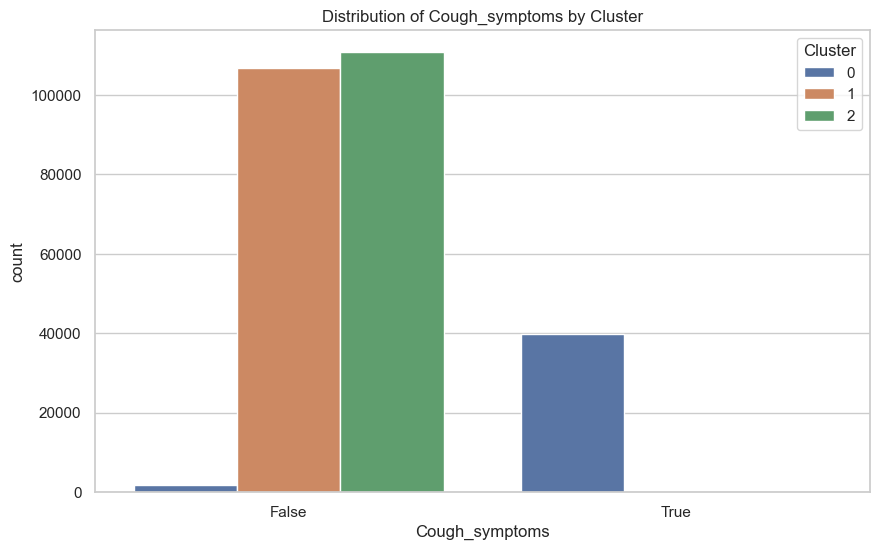

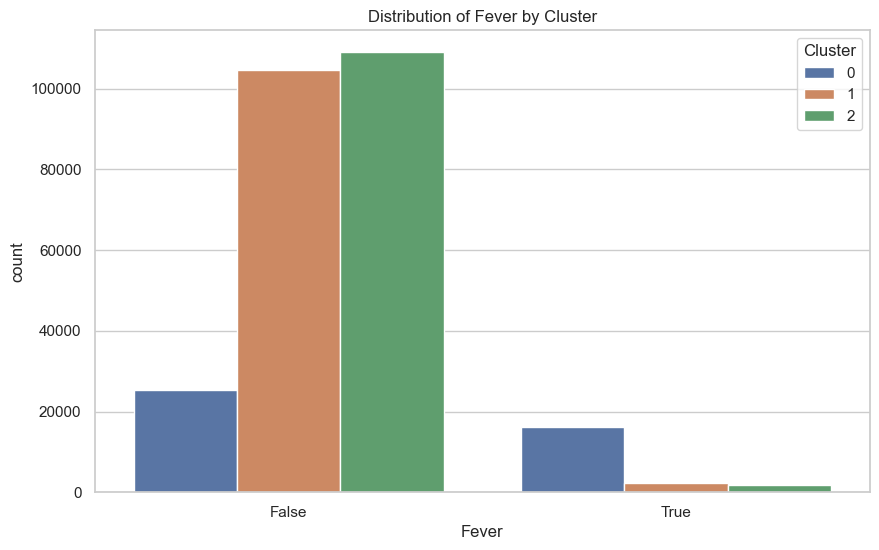

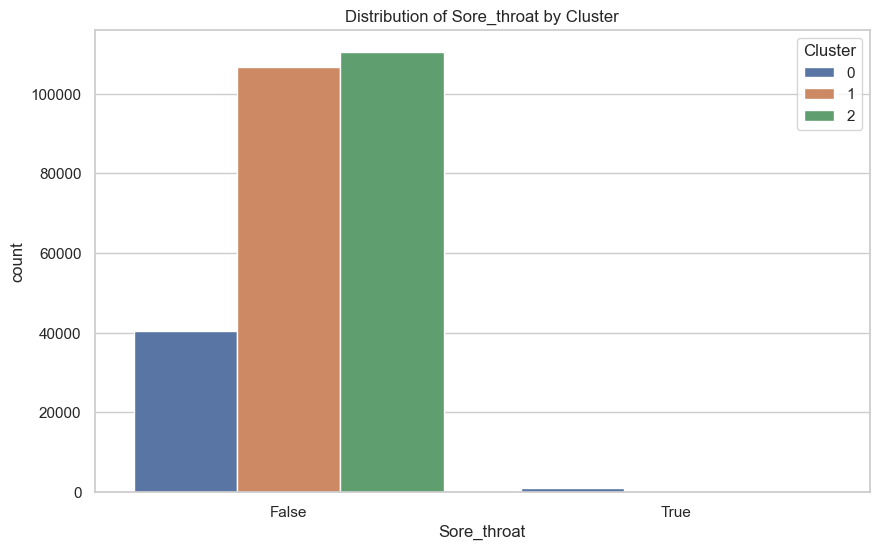

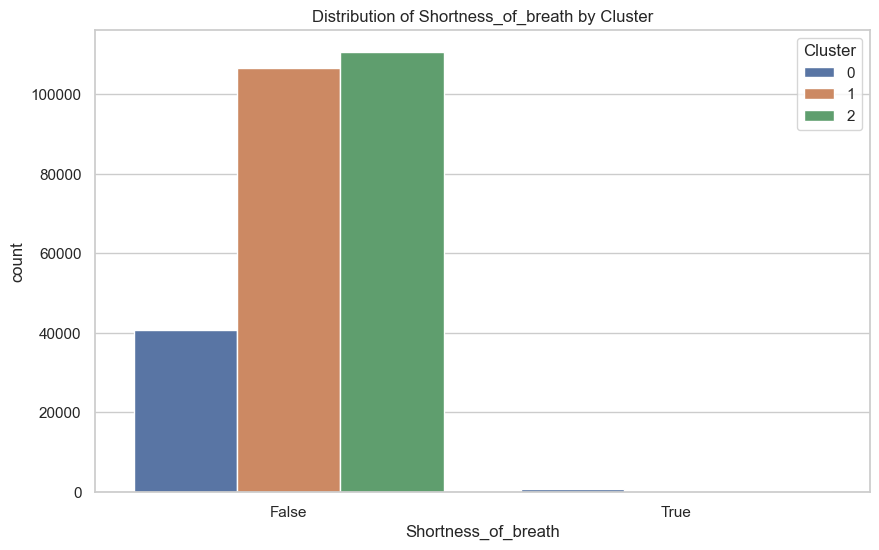

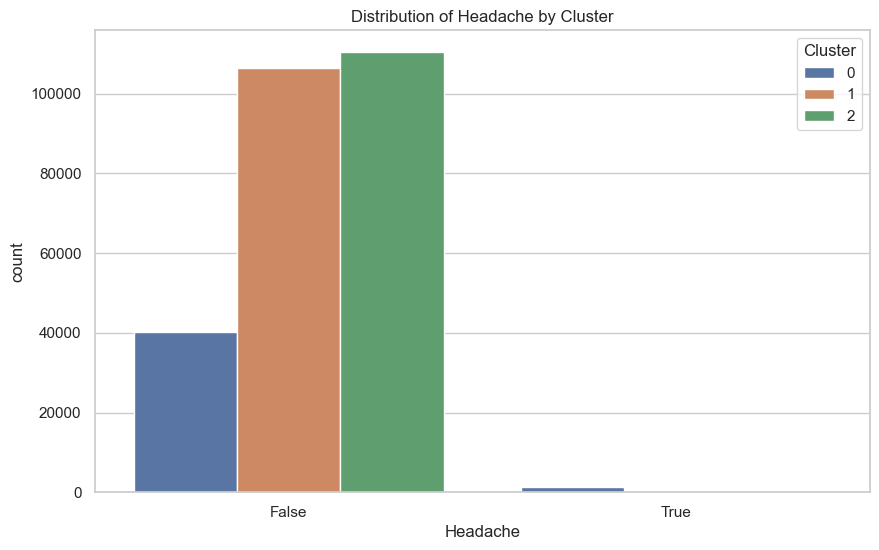

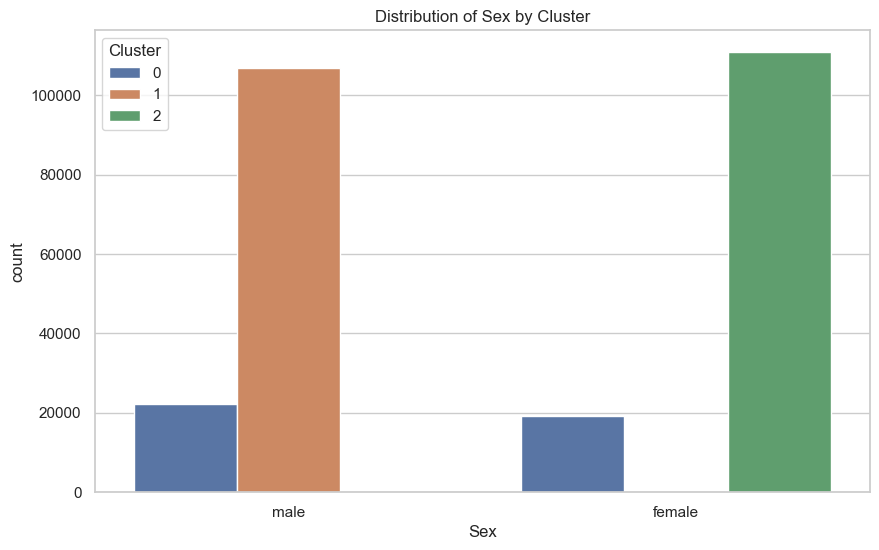

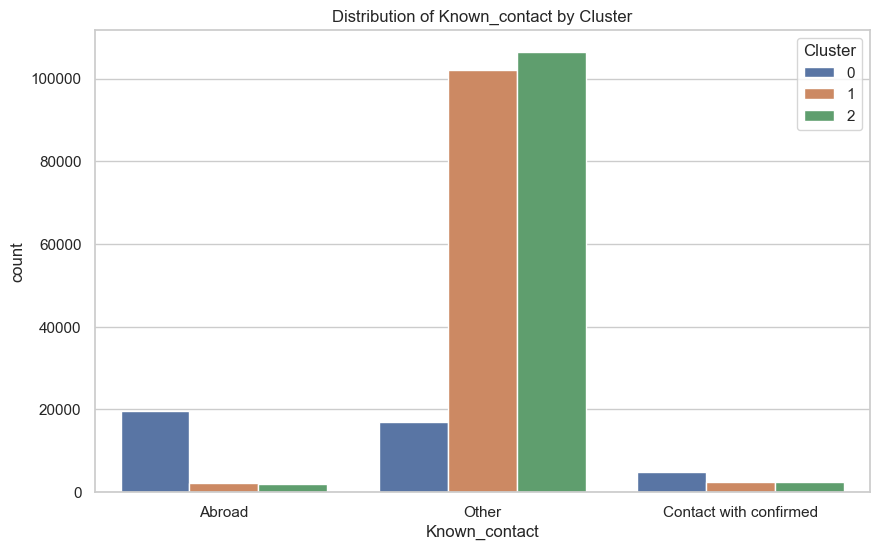

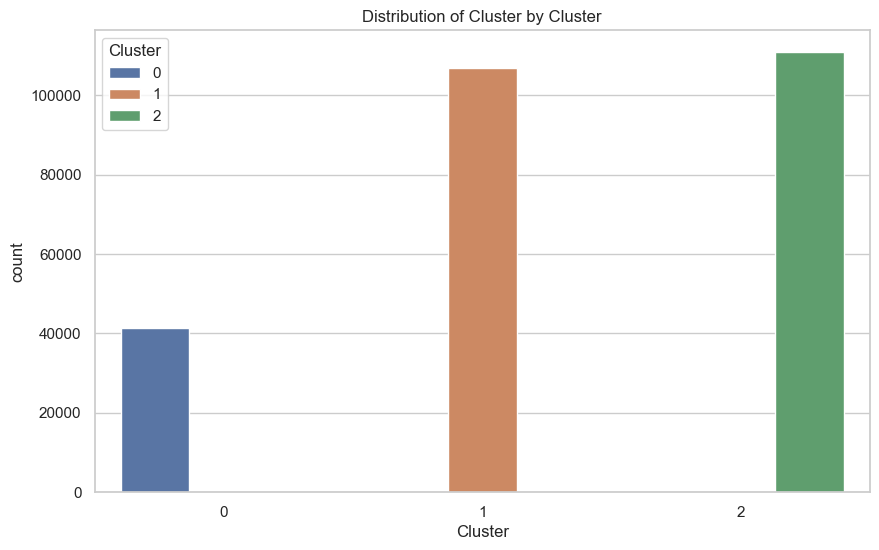

In [28]:
# Assuming you've used KMeans as shown previously
centroids = kmeans.cluster_centers_

# For scikit-learn 0.22 and newer
if hasattr(encoder, 'get_feature_names_out'):
    # Use get_feature_names_out for scikit-learn 0.22 and later
    original_feature_names = encoder.get_feature_names_out()
else:
    # Fallback for older versions, manually create feature names
    original_feature_names = []
    for i, cat in enumerate(encoder.categories_):
        original_feature_names.extend([f"{df_cluster_purpose.drop(columns='Corona').columns[i]}_{c}" for c in cat])

# Create a DataFrame with the centroids and the feature names
centroids_df = pd.DataFrame(centroids, columns=original_feature_names)

# Interpret the centroids
for feature in df_cluster_purpose.drop(columns='Corona').columns:
    # Find the columns corresponding to the feature
    related_cols = [col for col in centroids_df.columns if col.startswith(feature)]
    
    if related_cols:  # Ensure the list is not empty
        # Get the centroid values for these columns
        centroid_feature_values = centroids_df[related_cols]
        
        if not centroid_feature_values.empty:
            # Identify the highest value in each cluster's set of values for this feature
            dominant_category = centroid_feature_values.idxmax(axis=1)
            print(f"Dominant category for {feature} in each cluster:")
            print(dominant_category)
        else:
            print(f"No data available to determine the dominant category for {feature}.")
    else:
        print(f"No related columns found for feature {feature}.")


# Use count plots to visualize the distribution of categorical features within clusters
for col in df_cluster_purpose.drop(columns='Corona').columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Cluster', data=df_cluster_purpose)
    plt.title(f'Distribution of {col} by Cluster')
    plt.show()

Seems like Cluster 0 consistently had a higher "True" value for both risk factors (Abroad + known contact) and symptoms. Cluster 0 also has the highest percentage of positive cases compared to Clusters 1 and 2. 

Let's break down the distribution within clusters so that we aren't misled by the overwhelming negative cases. 

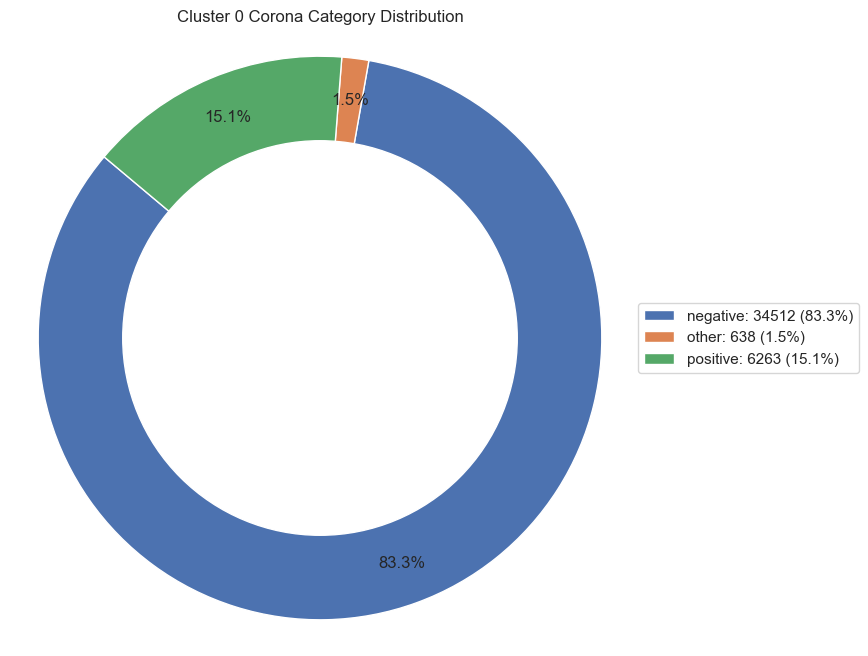

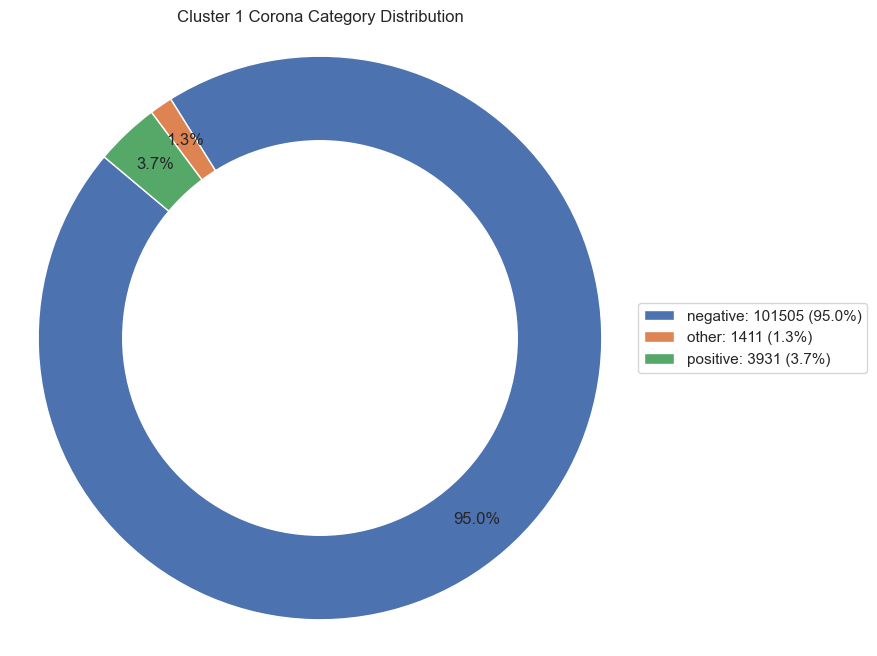

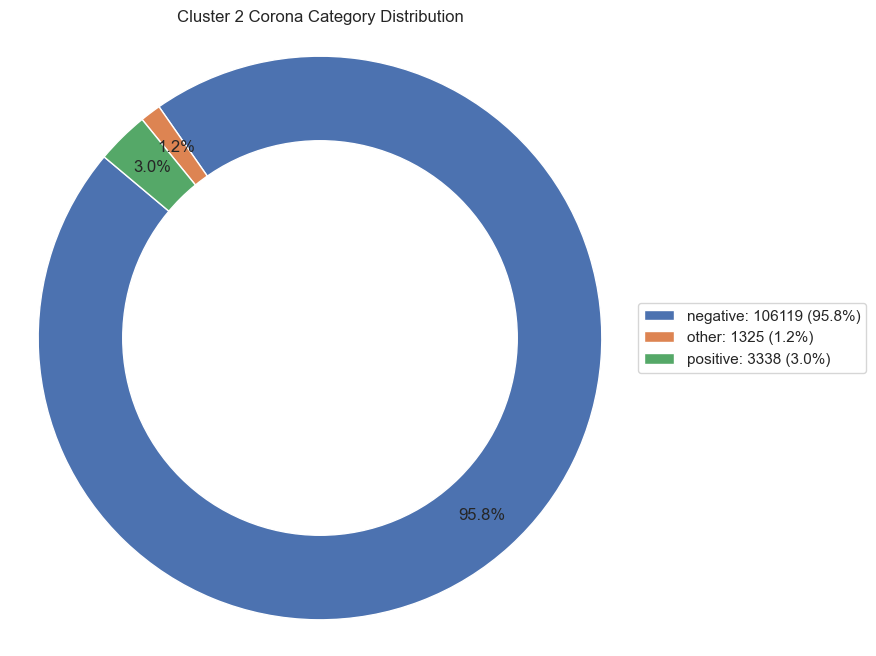

In [29]:
# Calculate the count of each 'Corona' category within each cluster
cluster_category_distribution = df_cluster_purpose.groupby(['Cluster', 'Corona']).size().unstack(fill_value=0)

# Plot a pie chart for each cluster with custom legend labels showing both count and percentage
for cluster in cluster_category_distribution.index:
    # Get the count and percentage for each 'Corona' category in the cluster
    counts = cluster_category_distribution.loc[cluster]
    total_count = counts.sum()
    percentages = (counts / total_count) * 100

    # Create custom labels for the legend
    labels = [f'{category}: {count} ({percentage:.1f}%)' for category, count, percentage in zip(counts.index, counts, percentages)]

    # Create the pie chart
    plt.figure(figsize=(8, 8))
    pie_wedges = plt.pie(counts, startangle=140, autopct='%1.1f%%', pctdistance=0.85)
    
    # Draw a circle at the center to make it a donut chart
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # Add the legend with the custom labels
    plt.legend(pie_wedges[0], labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(f'Cluster {cluster} Corona Category Distribution')
    plt.show()

18.90% (638/3374) of the "Other" values fall into Cluster 0, with majority negative cases, but 46.28% (6,263/13,532) of the "positive" values also fall into Cluster 0. That is nearly half of the positive cases in the same cluster as almost 19% of the "Other" values. While most of the "other" values fall into a cluster with less than 5% of positive cases, the 19% of "other" values that do not tells us that representing "other" as "negative" is not an option. The chance of a false negative would be too great in such a health context. 

It would be unwise to not consider the medical implications. If "Other" does in fact refer to an "inconclusive" test result, then categorizing "Other" cases as "positive" in the context of a pandemic response would be a more cautious approach. A common public health practice to prevent the spread from those who might be infectious but have not yet been confirmed is to treat inconclusive tests as positive until proven otherwise. 

We assume that the "Other" response is an inconclusive test because there are no NaNs in the "Corona" column, which might have indicated data unavaliability, as was the case for other features. 

Since deleting instances is a last resort, especially when dealing with a dataset that has health implications, and the dataset already has an imbalance issue between positive and negative cases, further removing the data could exacerbate the issue. 

In this case, to minimize the risk of false negatives, we will reclassify them as "positive" in order to err on the side of caution.

In [30]:
# Replace "Other" with "Positive" in target variable
df_modified['Corona'] = df_modified['Corona'].replace('other', 'positive')
df_modified['Corona'].unique()

array(['negative', 'positive'], dtype=object)

We have dealt with missing values! Now let's explore what kind of values we do have, and see how they are distributed to identify potential class imbalance issues. 

In [31]:
# ChatGPT generated this code so that it prints nicely!
for i in ['Cough_symptoms', 'Fever', 'Sore_throat',
          'Shortness_of_breath', 'Headache', 'Corona', 'Sex',
          'Known_contact']:
    print("The unique values and their percentage in '{}' are: ".format(i))
    value_counts = df_modified[i].value_counts(normalize=True, dropna=False) * 100
    for value, percentage in value_counts.items():
        print(f"  {value}: {percentage:.2f}%")
    print("-"*100)

The unique values and their percentage in 'Cough_symptoms' are: 
  False: 84.69%
  True: 15.31%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Fever' are: 
  False: 92.20%
  True: 7.80%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Sore_throat' are: 
  False: 99.41%
  True: 0.59%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Shortness_of_breath' are: 
  False: 99.58%
  True: 0.42%
----------------------------------------------------------------------------------------------------
The unique values and their percentage in 'Headache' are: 
  False: 99.18%
  True: 0.82%
----------------------------------------------------------------------------------------------------
The unique values and their perc

In [ ]:
# Explore Unique Values in Each Column
# Set the number of rows and columns for the subplot grid
r = 2  # 2 rows
c = 4  # 4 columns

it = 1  # Initializing subplot counter

# Set the figure size (optional, you can adjust it as needed)
plt.figure(figsize=(20, 10))

for i in df_modified.columns:
    plt.subplot(r, c, it)
    # Calculate the counts and percentages for the current column
    counts = df_modified[i].value_counts()
    percentages = (counts / counts.sum()) * 100
    # Combine counts and percentages for the legend
    labels = [f'{index} - {count} ({percentage:.2f}%)' for index, count, percentage in zip(counts.index, counts, percentages)]
    # Plot pie chart
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(i)
    # Place a legend on the chart
    plt.legend(labels, title="Counts and Percentages", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
    it += 1

plt.tight_layout()
plt.show()

Let's finish preparing the data by one-hot encoding our 8 categorical features. 

In [32]:
# One-hot encode the categorical features and ensure the dtype is integer
df_modified = pd.get_dummies(df_modified, columns=df_modified.columns, dtype=int)

# Assuming 'corona_positive' is 1 if positive and 0 otherwise
# 'corona_negative' is 1 if negative and 0 otherwise
# We want to create a single column 'Corona' that is 1 for positive and 0 for negative

df_modified['Corona'] = df_modified['Corona_positive']

# Now you can drop the one-hot encoded columns
df_modified.drop(['Corona_negative', 'Corona_positive'], axis=1, inplace=True)

# Display the first few rows of the encoded DataFrame to verify the dtypes
print(df_modified.head())

       Cough_symptoms_False  Cough_symptoms_True  Fever_False  Fever_True  \
13727                     0                    1            1           0   
13728                     0                    1            1           0   
13730                     0                    1            0           1   
13731                     1                    0            1           0   
13732                     1                    0            1           0   

       Sore_throat_False  Sore_throat_True  Shortness_of_breath_False  \
13727                  1                 0                          1   
13728                  1                 0                          1   
13730                  1                 0                          1   
13731                  1                 0                          1   
13732                  1                 0                          1   

       Shortness_of_breath_True  Headache_False  Headache_True  Sex_female  \
13727               

In [33]:
# Final Check
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259042 entries, 13727 to 278847
Data columns (total 16 columns):
 #   Column                                Non-Null Count   Dtype
---  ------                                --------------   -----
 0   Cough_symptoms_False                  259042 non-null  int64
 1   Cough_symptoms_True                   259042 non-null  int64
 2   Fever_False                           259042 non-null  int64
 3   Fever_True                            259042 non-null  int64
 4   Sore_throat_False                     259042 non-null  int64
 5   Sore_throat_True                      259042 non-null  int64
 6   Shortness_of_breath_False             259042 non-null  int64
 7   Shortness_of_breath_True              259042 non-null  int64
 8   Headache_False                        259042 non-null  int64
 9   Headache_True                         259042 non-null  int64
 10  Sex_female                            259042 non-null  int64
 11  Sex_male                   

In [5]:
# Features and labels
X = df.drop("Corona", axis=1)  # features (all columns except 'Corona')
y = df["Corona"]  # labels ('Corona' column)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **2: Modeling**

Wide and Deep learning models combine the strengths of two different types of architectures: a wide linear model that can memorize sparse feature interactions, and a deep neural network that can generalize to learn high-level feature interactions. We will incorporate multiple versions of these wide and deep learning models based on the context of classifying positive and negative cases of COVID-19. 

### **2.1: Training Our First Wide & Deep Neural Network**

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [13]:
from tensorflow.keras.utils import FeatureSpace

# Create the FeatureSpace for preprocessing
feature_space = FeatureSpace(
    features={
        # Categorical features encoded as boolean, treated as string for simplicity
        "Cough_symptoms": FeatureSpace.string_categorical(num_oov_indices=0),
        "Fever": FeatureSpace.string_categorical(num_oov_indices=0),
        "Sore_throat": FeatureSpace.string_categorical(num_oov_indices=0),
        "Shortness_of_breath": FeatureSpace.string_categorical(num_oov_indices=0),
        "Headache": FeatureSpace.string_categorical(num_oov_indices=0),
        "Sex": FeatureSpace.string_categorical(num_oov_indices=0),
        "Known_contact": FeatureSpace.string_categorical(num_oov_indices=0),
        
        # You might have additional numerical features to include here
        # "some_numerical_feature": FeatureSpace.float_normalized(),
    },
    crosses=[
        # Define the crossed features that you think may capture important interactions
        # For example, crossing 'Cough_symptoms' with 'Fever' if you believe there's an interaction
        FeatureSpace.cross(
            feature_names=('Cough_symptoms', 'Fever'),
            crossing_dim=2*2),  # Since both features are binary
        
        # Add more crosses as needed
        # FeatureSpace.cross(
        #     feature_names=('feature_a', 'feature_b'),
        #     crossing_dim=dim_a * dim_b),
    ],
    output_mode="concat",
)

2023-11-06 17:45:36.511500: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-06 17:45:36.512421: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-06 17:45:36.512653: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-06 17:45:36.514167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 17:45:36.515282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### **2.2: Training Our Second Wide & Deep Neural Network**

### **2.3: Training Our Last Wide & Deep Neural Network**

### **2.4: Evaluating the Performances of Our Three Models**